<a href="https://colab.research.google.com/github/benihime91/pytorch_examples/blob/master/nb_008_od_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Object Detection` using `FasterRCNN` with pretrained `ResNet50` backbone

## Initial Steps

In [48]:
!cp -R /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz /content/

In [ ]:
! tar zxvf /content/oxford-iiit-pet.tgz -C /content/

In [51]:
! pip install --upgrade albumentations bounding_box --quiet

## Preparing the data:

In [52]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET
from pathlib import Path
import cv2
import os
import shutil
from sklearn import model_selection, preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)

### Getting data into `csv` format.
- Gather the filepaths of the `valid` images.
- Gather the `bounding-box` `co-ordinates`. 
- Calculate the `area` of the `bounding-box`.
- Extract the `class_name` of the `images`.
- Convert the `class_name` to `integers`.

In [6]:
img_desc = Path("/content/oxford-iiit-pet/images")
ims = list(img_desc.iterdir())
ims = [str(pth) for pth in ims]

img_pths = []
print("[INFO] Gatering images")
# Accept only the image files
for im in tqdm(ims):
    if im.split(os.path.sep)[-1].split(".")[-1] == "jpg":
        img_pths.append(im)

img_pths[:5], len(img_pths)

[INFO] Gatering images


(['/content/oxford-iiit-pet/images/saint_bernard_168.jpg',
  '/content/oxford-iiit-pet/images/great_pyrenees_147.jpg',
  '/content/oxford-iiit-pet/images/Bengal_109.jpg',
  '/content/oxford-iiit-pet/images/Birman_104.jpg',
  '/content/oxford-iiit-pet/images/leonberger_28.jpg'],
 7390)

In [7]:
# Clear out the images that open_cv cannot open
for pth in tqdm(img_pths):
    try: _ = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
    except:
        img_pths.remove(pth)
        print(f"[INFO] Corrupted image: {pth}")

[INFO] Corrupted image: /content/oxford-iiit-pet/images/Egyptian_Mau_145.jpg
[INFO] Corrupted image: /content/oxford-iiit-pet/images/Egyptian_Mau_139.jpg
[INFO] Corrupted image: /content/oxford-iiit-pet/images/Egyptian_Mau_191.jpg
[INFO] Corrupted image: /content/oxford-iiit-pet/images/Egyptian_Mau_167.jpg
[INFO] Corrupted image: /content/oxford-iiit-pet/images/Egyptian_Mau_177.jpg
[INFO] Corrupted image: /content/oxford-iiit-pet/images/Abyssinian_34.jpg



In [8]:
annot_dir = Path("/content/oxford-iiit-pet/annotations/xmls")
annots = list(annot_dir.iterdir())
annots = [str(a) for a in annots]

ann_pths = []
print("[INFO] Creating the paths to the annotations ...")
for a in tqdm(annots):
    for i in img_pths:
        # Check if the annotation file for an image is in 
        # our verified img_pths or not
        i_pth = i.split(os.path.sep)[-1].split(".")[0]
        a_pth = a.split(os.path.sep)[-1].split(".")[0]
        if i_pth == a_pth : ann_pths.append(a)
print("Annotation files found : ", len(ann_pths))

[INFO] Creating the paths to the annotations ...



Annotation files found :  3686


In [10]:
def xml_to_csv(pths:list) -> pd.DataFrame:
    """Extracts the filenames and the bboxes from the xml_list"""
    print("[INFO] Gathering the filenames and bboxes")
    xml_list = []
    for xml_file in tqdm(pths):
        # Read in the xml file
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for m in root.findall("object"):
            try:
                value = (
                    # Extract the path to the image
                    str(img_desc/root.find("filename").text),
                    # Extract the bounding boxes
                    # 1. xmin
                    float(m[4][0].text),
                    # 2. ymin
                    float(m[4][1].text),
                    # 3. xmax
                    float(m[4][2].text),
                    # 4. ymax
                    float(m[4][3].text),
                )
                xml_list.append(value)
            except: pass
    col_n = ["filename", "xmin", "ymin", "xmax", "ymax"]
    df = pd.DataFrame(xml_list, columns=col_n)
    return df

In [11]:
df = xml_to_csv(ann_pths)

[INFO] Gathering the filenames and bboxes


In [12]:
# Let's extract the labels from the image filename &
# convert the labels into ints, shuffle the DataFrame

pat = r'/([^/]+)_\d+.jpg$'
pat = re.compile(pat)

# 1. Extract the label
df["class"] = [pat.search(fname).group(1).lower() for fname in df.filename]
# 2. Convert the classes to integers
df["target"] = preprocessing.LabelEncoder().fit_transform(df["class"].values) + 1
# 3. Shuffle the dataFrame
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,filename,xmin,ymin,xmax,ymax,class,target
0,/content/oxford-iiit-pet/images/pug_13.jpg,67.0,41.0,382.0,272.0,pug,26
1,/content/oxford-iiit-pet/images/pomeranian_174.jpg,88.0,10.0,214.0,135.0,pomeranian,25
2,/content/oxford-iiit-pet/images/wheaten_terrier_115.jpg,142.0,126.0,239.0,236.0,wheaten_terrier,36
3,/content/oxford-iiit-pet/images/english_cocker_spaniel_102.jpg,88.0,25.0,200.0,175.0,english_cocker_spaniel,13
4,/content/oxford-iiit-pet/images/shiba_inu_160.jpg,300.0,59.0,450.0,241.0,shiba_inu,32


### `EDA`

In [13]:
print("[INFO] Number of unique classes:", len(df["class"].unique()))
print("[INFO] Number of unique images: ", len(df["filename"].unique()))

[INFO] Number of unique classes: 37
[INFO] Number of unique images:  3686


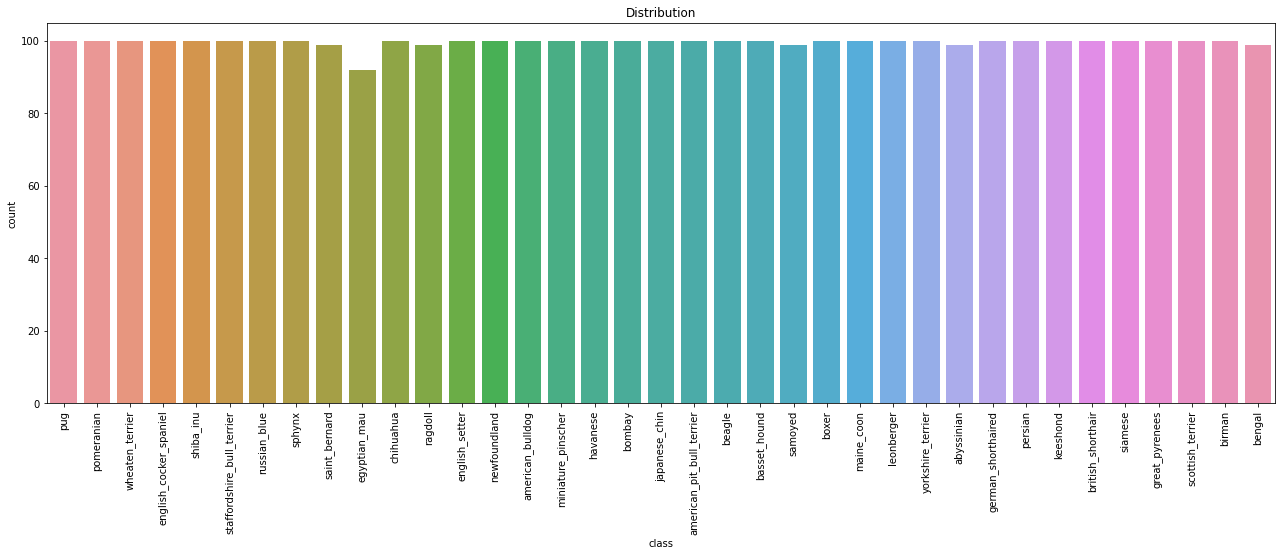

In [14]:
_, ax = plt.subplots(1, 1, figsize=(22, 7))
sns.countplot(x=df["class"], ax=ax)
ax.set_title("Distribution")
plt.xticks(rotation=90);

In [15]:
from bounding_box import bounding_box as bb
from google.colab.patches import cv2_imshow

def view_rndm_sample(color="fuchsia"):
    n = np.random.randint(0, len(df))
    im = cv2.cvtColor(cv2.imread(df.filename[n]), cv2.COLOR_BGR2RGB)
    bb.add(im, df["xmin"][n], df["ymin"][n], df["xmax"][n], df["ymax"][n],
           df["class"][n], color=color)
    cv2_imshow(im)

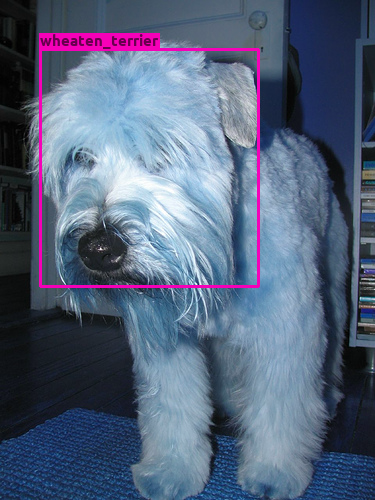

In [16]:
view_rndm_sample()

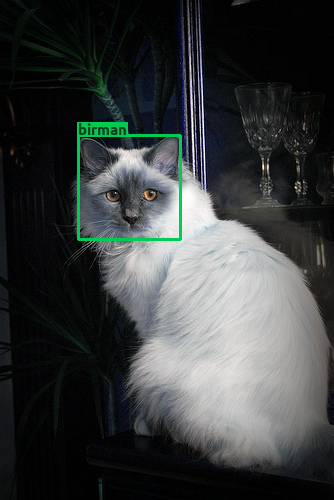

In [17]:
view_rndm_sample(color="green")

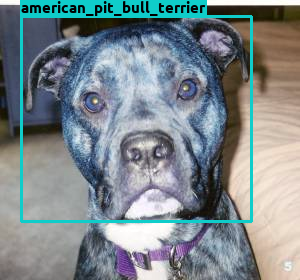

In [19]:
view_rndm_sample(color="teal")

In [20]:
# Save the dataframe
df.to_csv("/content/drive/My Drive/Data/pet_img_files_annots.csv", index=False)

### `Split` our `data` into `training` & `validation` sets.

In [3]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET
from pathlib import Path
import cv2
import os
import shutil
from sklearn import model_selection, preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)

In [4]:
df = pd.read_csv("/content/drive/My Drive/Data/pet_img_files_annots.csv")
df.head()

,filename,xmin,ymin,xmax,ymax,class,target
0,/content/oxford-iiit-pet/images/pug_13.jpg,67.0,41.0,382.0,272.0,pug,26
1,/content/oxford-iiit-pet/images/pomeranian_174.jpg,88.0,10.0,214.0,135.0,pomeranian,25
2,/content/oxford-iiit-pet/images/wheaten_terrier_115.jpg,142.0,126.0,239.0,236.0,wheaten_terrier,36
3,/content/oxford-iiit-pet/images/english_cocker_spaniel_102.jpg,88.0,25.0,200.0,175.0,english_cocker_spaniel,13
4,/content/oxford-iiit-pet/images/shiba_inu_160.jpg,300.0,59.0,450.0,241.0,shiba_inu,32


In [5]:
# Dictionary mapping from target to class
trgt_dict = {t:c for t, c in list(zip(list(df.target.unique()), list(df["class"].unique())))}
trgt_dict

{1: 'abyssinian',
 2: 'american_bulldog',
 3: 'american_pit_bull_terrier',
 4: 'basset_hound',
 5: 'beagle',
 6: 'bengal',
 7: 'birman',
 8: 'bombay',
 9: 'boxer',
 10: 'british_shorthair',
 11: 'chihuahua',
 12: 'egyptian_mau',
 13: 'english_cocker_spaniel',
 14: 'english_setter',
 15: 'german_shorthaired',
 16: 'great_pyrenees',
 17: 'havanese',
 18: 'japanese_chin',
 19: 'keeshond',
 20: 'leonberger',
 21: 'maine_coon',
 22: 'miniature_pinscher',
 23: 'newfoundland',
 24: 'persian',
 25: 'pomeranian',
 26: 'pug',
 27: 'ragdoll',
 28: 'russian_blue',
 29: 'saint_bernard',
 30: 'samoyed',
 31: 'scottish_terrier',
 32: 'shiba_inu',
 33: 'siamese',
 34: 'sphynx',
 35: 'staffordshire_bull_terrier',
 36: 'wheaten_terrier',
 37: 'yorkshire_terrier'}

In [6]:
split = model_selection.train_test_split

df_trn, df_val = split(df, stratify=df.target, random_state=42, shuffle=True, test_size=0.1)

df_trn.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

print("[INFO] No. of training examples: ", len(df_trn))
print("[INFO] No. of validation examples: ", len(df_val))

[INFO] No. of training examples:  3318
[INFO] No. of validation examples:  369


In [7]:
df_trn.head(2)

,filename,xmin,ymin,xmax,ymax,class,target
0,/content/oxford-iiit-pet/images/beagle_158.jpg,214.0,90.0,306.0,164.0,beagle,5
1,/content/oxford-iiit-pet/images/British_Shorthair_190.jpg,152.0,1.0,464.0,260.0,british_shorthair,10


In [8]:
df_val.head(2)

,filename,xmin,ymin,xmax,ymax,class,target
0,/content/oxford-iiit-pet/images/american_pit_bull_terrier_163.jpg,5.0,38.0,131.0,159.0,american_pit_bull_terrier,3
1,/content/oxford-iiit-pet/images/basset_hound_10.jpg,99.0,64.0,397.0,314.0,basset_hound,4


### Create a `torch.utils.data.Dataset` instance to gather our data.

In [64]:
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from bounding_box import bounding_box as bb
from google.colab.patches import cv2_imshow
import sys

In [65]:
# We can train without resing our images to a uniform shape
# because the model will have only Conv Layers

# Train transforms
trn_tfms = A.Compose([
    A.ToGray(p=0.2),
    A.HorizontalFlip(),
    A.Rotate(limit=60),
    A.CLAHE(),
    A.IAASharpen(),
    A.IAAPerspective(),
    A.ToFloat(max_value=255.0, always_apply=True),
    ToTensorV2(always_apply=True),
], p=1., bbox_params=A.BboxParams(format="pascal_voc"))

# Validation transforms
val_tfms = A.Compose([
    A.ToFloat(max_value=255.0, always_apply=True),
    ToTensorV2(always_apply=True),   
], p=1., bbox_params=A.BboxParams(format="pascal_voc"))

In [66]:
class ParseData(Dataset):
    def __init__(self, dataframe:pd.DataFrame, trn:bool=False):
        self.df = dataframe
        if trn:  self.tfms = trn_tfms
        else:    self.tfms = val_tfms
                
    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        # read in the image
        im = cv2.cvtColor(cv2.imread(self.df.filename[idx]), cv2.COLOR_BGR2RGB)
        # parse the bboxes
        bboxes = []
        bboxes.append(self.df.xmin[idx])
        bboxes.append(self.df.ymin[idx])
        bboxes.append(self.df.xmax[idx])
        bboxes.append(self.df.ymax[idx])

        # apply transfromations
        bboxes.append(self.df["target"][idx])
        trns = self.tfms(image=im, bboxes=[bboxes])
        try: im, bboxes = trns["image"], trns["bboxes"][0][:4]
        except : 
            print(f"[INFO] Something wrong ... {self.df.filename[idx]}")
            sys.exit(0)

        # convert everything to torch.tensor
        image_id = torch.tensor([idx])
        trgt = torch.tensor((self.df["target"][idx], ), dtype=torch.int64)
        bboxes = torch.as_tensor([bboxes], dtype=torch.float32)
        area = torch.tensor(((bboxes[0][3] - bboxes[0][1]) * (bboxes[0][2] - bboxes[0][0]), ), dtype=torch.float32)
        iscrowd = torch.zeros((1, ), dtype=torch.int64)
        # Create target dictionary
        target = {}
        target["boxes"] = bboxes
        target["labels"] = trgt
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return im, target

image dims:  torch.Size([3, 375, 500])
bbox coordinates:  190.12799 0.0 476.44055 220.88443
bbox area:  63241.99
image_id:  2736
label:  31
target_dict:  {'boxes': tensor([[190.1280,   0.0000, 476.4406, 220.8844]]), 'labels': tensor([31]), 'image_id': tensor([2736]), 'area': tensor([63241.9883]), 'iscrowd': tensor([0])}


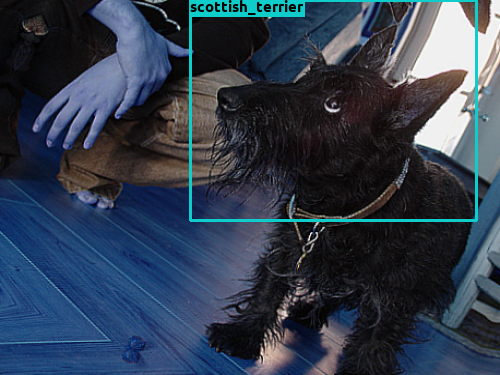

In [69]:
# Sanity Check

# Display a random sample from the dataset
n = np.random.randint(0, len(df))

tmp = ParseData(df, trn=True)
i,t = tmp.__getitem__(n)

trgt = int(t["labels"][0].numpy())

t_xmin = t["boxes"][0][0].numpy()
t_ymin = t["boxes"][0][1].numpy()
t_xmax = t["boxes"][0][2].numpy()
t_ymax = t["boxes"][0][3].numpy()

# Print Info
print("image dims: ", i.size())
print("bbox coordinates: ", t_xmin, t_ymin, t_xmax, t_ymax)
print("bbox area: ", t["area"][0].numpy())
print("image_id: ", t["image_id"][0].numpy())
print("label: ", t["labels"][0].numpy())
print("target_dict: ", t)

# De-Normalize the image?
im = i.permute(1, 2, 0).numpy()*255.0
# Add the bounding box
bb.add(im, t_xmin, t_ymin, t_xmax, t_ymax, trgt_dict[trgt], color="teal")
# display the image
cv2_imshow(im)

### Create `torch.utils.data.DataLoader` instance(s) from the training and validaiton `DataFrames` using `torch.utils.data.Dataset`

In [13]:
def collate_fn(batch): return tuple(zip(*batch))

In [14]:
trn_dl = DataLoader(ParseData(df_trn, True), batch_size=2, collate_fn=collate_fn, shuffle=True)

val_dl = DataLoader(ParseData(df_val, False), batch_size=2, collate_fn=collate_fn)

In [15]:
# grab number of unique_classes
# add + 1 beacause background will be 0
n_c = len(df.target.unique()) + 1
n_c

38

### Defining our `model`
- We will be using a `FasterRCNN` with a `ResNet50` backbone pretrained on the `COCO` dataset.

In [16]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load pre-trained model on pretrained COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [17]:
# we will ned to replace the classifer with a new one
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_c)

## Set-up a `training` & `evaluation` `framework` for `model`.

### Let's `create` a `training` framework that we can use to train this network.

In [73]:
! git clone https://github.com/pytorch/vision.git

Cloning into 'vision'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 9283 (delta 8), reused 4 (delta 1), pack-reused 9258
Receiving objects: 100% (9283/9283), 11.25 MiB | 1.94 MiB/s, done.
Resolving deltas: 100% (6430/6430), done.


In [18]:
os.chdir("/content/vision/references/detection/")

from typing import Dict, Tuple, Sequence, Union
from engine import evaluate
from IPython import display
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); device

device(type='cuda', index=0)

- one batch of our `dataloader` will contain 2 items: 
1. `images`
2. `targets`
- During `training` phase the `model` will return 4 losses:
1. `loss_box_reg`
2. `loss_classifier`
3. `loss_objectness`
4. `loss_rpn_box_reg`

In [26]:
def train_step(model, batch, optimizer, scheduler=None, clip=False) -> Union[float, float, float]:
    # Unpack a single batch
    images, targets = batch
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    # Calculate loss during the forward pass
    loss_dict = model(images, targets)
    # total loss
    losses = sum(n for n in loss_dict.values())

    # store the loss values
    loss = losses.item()
    box = loss_dict["loss_box_reg"].item() 
    clf = loss_dict["loss_classifier"].item()

    # Update weights
    optimizer.zero_grad()
    losses.backward()
    if clip: torch.nn.utils.clip_grad_value_(model.parameters(), 0.1)
    optimizer.step()
    if scheduler is not None: scheduler.step()

    # Return the toal loss, loss of the box_reg and loss of the classifier
    return loss, box, clf

In [27]:
stat = "[INFO] batch [ {}/{}] - loss={:.4f} loss_box_reg={:.4f} loss_classifier={:.4f}"

def train_one_epoch(model, dl, optimizer, scheduler=None, clip=False, print_every=100) -> Union[float, float, float]:
    avg_loss, box_loss, classifier_loss = 0., 0., 0.
    bar = tqdm(dl, total=len(dl), leave=False)
    # Iterate over the batches
    for n, batch in enumerate(bar):
        loss, loss_box, loss_classifier = train_step(model, batch, optimizer, scheduler, clip)
        
        # print stats every print_every
        if n == 0 or n % print_every == 0:   print(stat.format(n+1, len(dl), loss, loss_box, loss_classifier))
        
        # accumulate the losses
        avg_loss += loss
        box_loss += loss_box
        
        classifier_loss += loss_classifier
    # Return the avg losses
    return avg_loss/len(dl), box_loss/len(dl), classifier_loss/len(dl)

In [28]:
prompt = "[INFO] Epoch {} - training_loss={:.4f} loss_box_reg={:.4f} loss_classifier={:.4f}"

def fit(index:int, model, train_loader, val_loader, optimizer, scheduler=None, clip=False, refresh:bool=True) -> None:
    print(f"[INFO] Epoch {index+1}")
    print("[INFO] Training .... ")
    # Train the model
    model.train()
    avg_loss, box_loss, classifier_loss = train_one_epoch(model,train_loader, optimizer, scheduler, clip)

    # Save model to keep progress
    print("[INFO] saving model ....")
    torch.save(model.state_dict(), "/content/drive/My Drive/model_stage-01.pt")
    if refresh: display.clear_output()

    # Print training stats
    print(prompt.format(index+1, avg_loss, box_loss, classifier_loss))
    print("[INFO] Evaluating ...")

    # evaluate using pre-defined pytorch function
    model.eval()
    evaluate(model, val_loader, device=device)

## Begin `training`

In [108]:
# EPOCHS = 6 #@param{type:"integer"}
# EPOCHS = 2 #@param{type:"integer"}
# EPOCHS = 2 #@param{type:"integer"}
# EPOCHS = 2 #@param{type:"integer"}
# EPOCHS = 2 #@param{type:"integer"}
# EPOCHS = 2 #@param{type:"integer"}
EPOCHS = 2 #@param{type:"integer"}

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=1e-03,
    momentum=0.9,
    weight_decay=1e-03)

one_c = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-03,
    steps_per_epoch=len(trn_dl),
    epochs=EPOCHS)

In [109]:
model.load_state_dict(torch.load("/content/drive/My Drive/model_stage-01.pt", map_location=device))

<All keys matched successfully>

In [110]:
for n in range(EPOCHS):
    torch.cuda.empty_cache()
    model.to(device)
    fit(n, model, trn_dl, val_dl, optimizer, scheduler=one_c, clip=True, refresh=False)

[INFO] Epoch 1
[INFO] Training .... 


[INFO] batch [ 1/1659] - loss=0.1042 loss_box_reg=0.0094 loss_classifier=0.0268
[INFO] batch [ 101/1659] - loss=0.0768 loss_box_reg=0.0336 loss_classifier=0.0400
[INFO] batch [ 201/1659] - loss=0.0640 loss_box_reg=0.0223 loss_classifier=0.0377
[INFO] batch [ 301/1659] - loss=0.0923 loss_box_reg=0.0386 loss_classifier=0.0482
[INFO] batch [ 401/1659] - loss=0.1683 loss_box_reg=0.0373 loss_classifier=0.1233
[INFO] batch [ 501/1659] - loss=0.0585 loss_box_reg=0.0187 loss_classifier=0.0342
[INFO] batch [ 601/1659] - loss=0.1156 loss_box_reg=0.0344 loss_classifier=0.0740
[INFO] batch [ 701/1659] - loss=0.1191 loss_box_reg=0.0431 loss_classifier=0.0736
[INFO] batch [ 801/1659] - loss=0.1158 loss_box_reg=0.0259 loss_classifier=0.0678
[INFO] batch [ 901/1659] - loss=0.0361 loss_box_reg=0.0097 loss_classifier=0.0181
[INFO] batch [ 1001/1659] - loss=0.1650 loss_box_reg=0.0332 loss_classifier=0.1258
[INFO] batch [ 1101/1659] - loss=0.0703 loss_box_reg=0.0201 loss_classifier=0.0471
[INFO] batch [ 1

[INFO] batch [ 1/1659] - loss=0.1043 loss_box_reg=0.0280 loss_classifier=0.0487
[INFO] batch [ 101/1659] - loss=0.1270 loss_box_reg=0.0298 loss_classifier=0.0758
[INFO] batch [ 201/1659] - loss=0.0641 loss_box_reg=0.0199 loss_classifier=0.0389
[INFO] batch [ 301/1659] - loss=0.0968 loss_box_reg=0.0434 loss_classifier=0.0469
[INFO] batch [ 401/1659] - loss=0.1772 loss_box_reg=0.0510 loss_classifier=0.1217
[INFO] batch [ 501/1659] - loss=0.2141 loss_box_reg=0.0586 loss_classifier=0.1428
[INFO] batch [ 601/1659] - loss=0.0437 loss_box_reg=0.0122 loss_classifier=0.0269
[INFO] batch [ 701/1659] - loss=0.0672 loss_box_reg=0.0150 loss_classifier=0.0255
[INFO] batch [ 801/1659] - loss=0.0739 loss_box_reg=0.0146 loss_classifier=0.0547
[INFO] batch [ 901/1659] - loss=0.0442 loss_box_reg=0.0165 loss_classifier=0.0228
[INFO] batch [ 1001/1659] - loss=0.0875 loss_box_reg=0.0246 loss_classifier=0.0577
[INFO] batch [ 1101/1659] - loss=0.1260 loss_box_reg=0.0214 loss_classifier=0.0854
[INFO] batch [ 1

## Inference

In [111]:
from bounding_box import bounding_box as bb
import cv2 
import torch
from torchvision import models
import numpy as np
from torchvision import transforms as T
import warnings
import sys
from google.colab import files
from google.colab.patches import cv2_imshow

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")
%matplotlib inline

In [112]:
model.load_state_dict(torch.load("/content/drive/My Drive/model_stage-01.pt", map_location=device))

<All keys matched successfully>

In [113]:
@torch.no_grad()
def get_preds(path, threshold):
    model.to(device)
    torch.cuda.empty_cache()
    print("[INFO] Loading image ... ")
    # Load the image
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    # Process the image
    img = val_tfms(image=img)["image"]
    img = img.to(device)
    model.eval()
    # Generate predictions
    pred = model([img])
    # Get the Predicted Classes
    # pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_class = [ trgt_dict[i] for i in list(pred[0]['labels'].cpu().numpy()) ]
    # Bounding Boxes
    pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(pred[0]['boxes'].cpu().numpy())]
    # Get list of index with score greater than threshold.
    pred_score = list(pred[0]['scores'].cpu().numpy())
    # Check if predictions are present with greater than threshold or not
    try: pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    except: 
        print("[INFO] No object detected within given threshold ...")
        sys.exit(0)
    # Grab the boxes & classes with score greater than threshold
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

In [114]:
def object_detection_api(img_path, threshold=0.5)->None:
    print("[INFO] Generating predicitons ....")
    bboxes, pred_cls = get_preds(img_path, threshold)
    print("[INFO] Creating bbox on the image .... ")
    img = cv2.imread(img_path)
    for i in range(len(bboxes)):
        xmin, ymin, xmax, ymax = bboxes[i][0], bboxes[i][1], bboxes[i][2], bboxes[i][3]
        bb.add(img, xmin, ymin, xmax, ymax, pred_cls[i], color="green")
    print("[INFO] Generating result(s) .... ")   
    cv2_imshow(img)

In [115]:
uploaded = files.upload()

Saving wheaten_terrier_108.jpg to wheaten_terrier_108.jpg


[INFO] Generating predicitons ....
[INFO] Loading image ... 
[INFO] Creating bbox on the image .... 
[INFO] Generating result(s) .... 


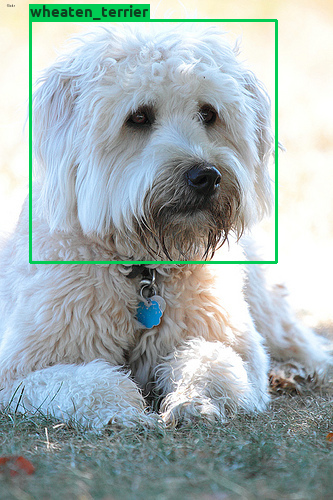

In [116]:
object_detection_api(list(uploaded.keys())[0], threshold=0.5)

Saving Abyssinian_16.jpg to Abyssinian_16.jpg
[INFO] Generating predicitons ....
[INFO] Loading image ... 
[INFO] Creating bbox on the image .... 
[INFO] Generating result(s) .... 


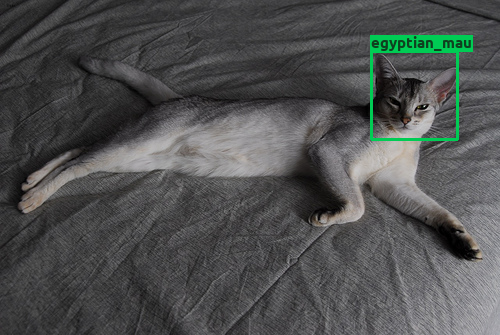

In [117]:
uploaded = files.upload()
object_detection_api(list(uploaded.keys())[0], threshold=0.5)

Saving Abyssinian_12.jpg to Abyssinian_12.jpg
[INFO] Generating predicitons ....
[INFO] Loading image ... 
[INFO] Creating bbox on the image .... 
[INFO] Generating result(s) .... 


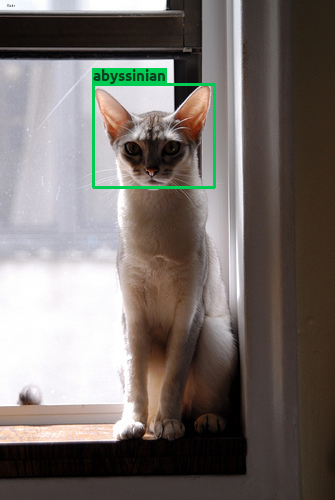

In [120]:
uploaded = files.upload()
object_detection_api(list(uploaded.keys())[0], threshold=0.4)

Saving american_bulldog_41.jpg to american_bulldog_41.jpg
[INFO] Generating predicitons ....
[INFO] Loading image ... 
[INFO] Creating bbox on the image .... 
[INFO] Generating result(s) .... 


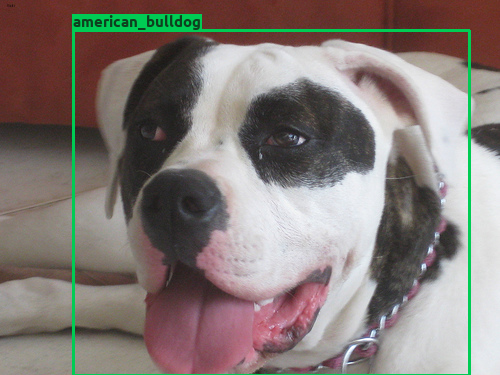

In [121]:
uploaded = files.upload()
object_detection_api(list(uploaded.keys())[0], threshold=0.5)

Saving basset_hound_190.jpg to basset_hound_190.jpg
[INFO] Generating predicitons ....
[INFO] Loading image ... 
[INFO] Creating bbox on the image .... 
[INFO] Generating result(s) .... 


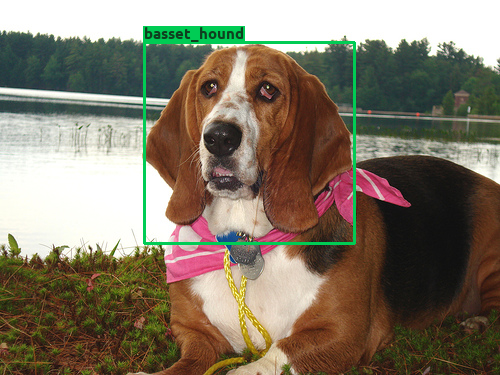

In [122]:
uploaded = files.upload()
object_detection_api(list(uploaded.keys())[0], threshold=0.5)